<a href="https://colab.research.google.com/github/Yukkitsune/TBank-Analytics/blob/main/Machine%20learning/Boostings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание: Решающие деревья, ансамбли и бустинг

Датасет: [Bank Marketing Dataset](https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset) (предсказание, подпишется ли клиент на депозит)

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from catboost import CatBoostClassifier

In [ ]:
# Download latest version
BANK_PATH = kagglehub.dataset_download("janiobachmann/bank-marketing-dataset")

print("Path to dataset files:", BANK_PATH)

Path to dataset files: C:\Users\akito\.cache\kagglehub\datasets\janiobachmann\bank-marketing-dataset\versions\1


# Первичный анализ данных ( 1 балл)

- Загрузите данные и выполните первичный анализ

- Проведите анализ распределения целевой переменной

- Выявите и обработайте пропущенные значения в данных
- Преобразуй категориальные данные в числовые (LabelEncoder)
- Разделите данные на обучающую и тестовую выборки в соотношении 80/20


In [ ]:
df = pd.read_csv(f'{BANK_PATH}/bank.csv', sep=',')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


Видим, что абсолютно все данные заполнены, пропусков нет

In [ ]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [ ]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


Построим распределение таргета и остальных фичей

In [ ]:
df['deposit'].value_counts()

deposit
no     5873
yes    5289
Name: count, dtype: int64

In [ ]:
def plot_feature(df:pd.DataFrame, column: str, figsize: tuple):
    plt.figure(figsize=figsize)
    if df[column].dtype == 'int64':
        sns.histplot(df[column], kde=True)
    else:
        sns.barplot(x=df[column].value_counts().index, y=df[column].value_counts().values)
        plt.xticks(rotation=45)
    plt.title(f'Распределение {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

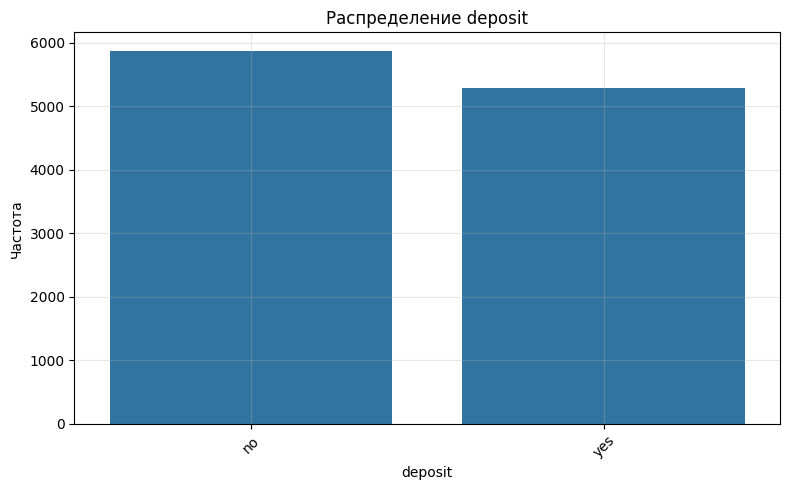

In [ ]:
plot_feature(df, 'deposit', (8, 5))

In [ ]:
def plot_all_features(df: pd.DataFrame):
    num_cols = df.shape[1]
    num_rows = (num_cols + 2) // 3
    plt.figure(figsize=(18, 5 * num_rows))
    for i, column in enumerate(df.columns):
        plt.subplot(num_rows, 3, i + 1)
        if df[column].dtype == 'int64':
            sns.histplot(df[column], kde=True)
        else:
            sns.barplot(x=df[column].value_counts().index, y=df[column].value_counts().values)
            plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.title(f'Распределение {column}')
        plt.tight_layout()
    plt.show()

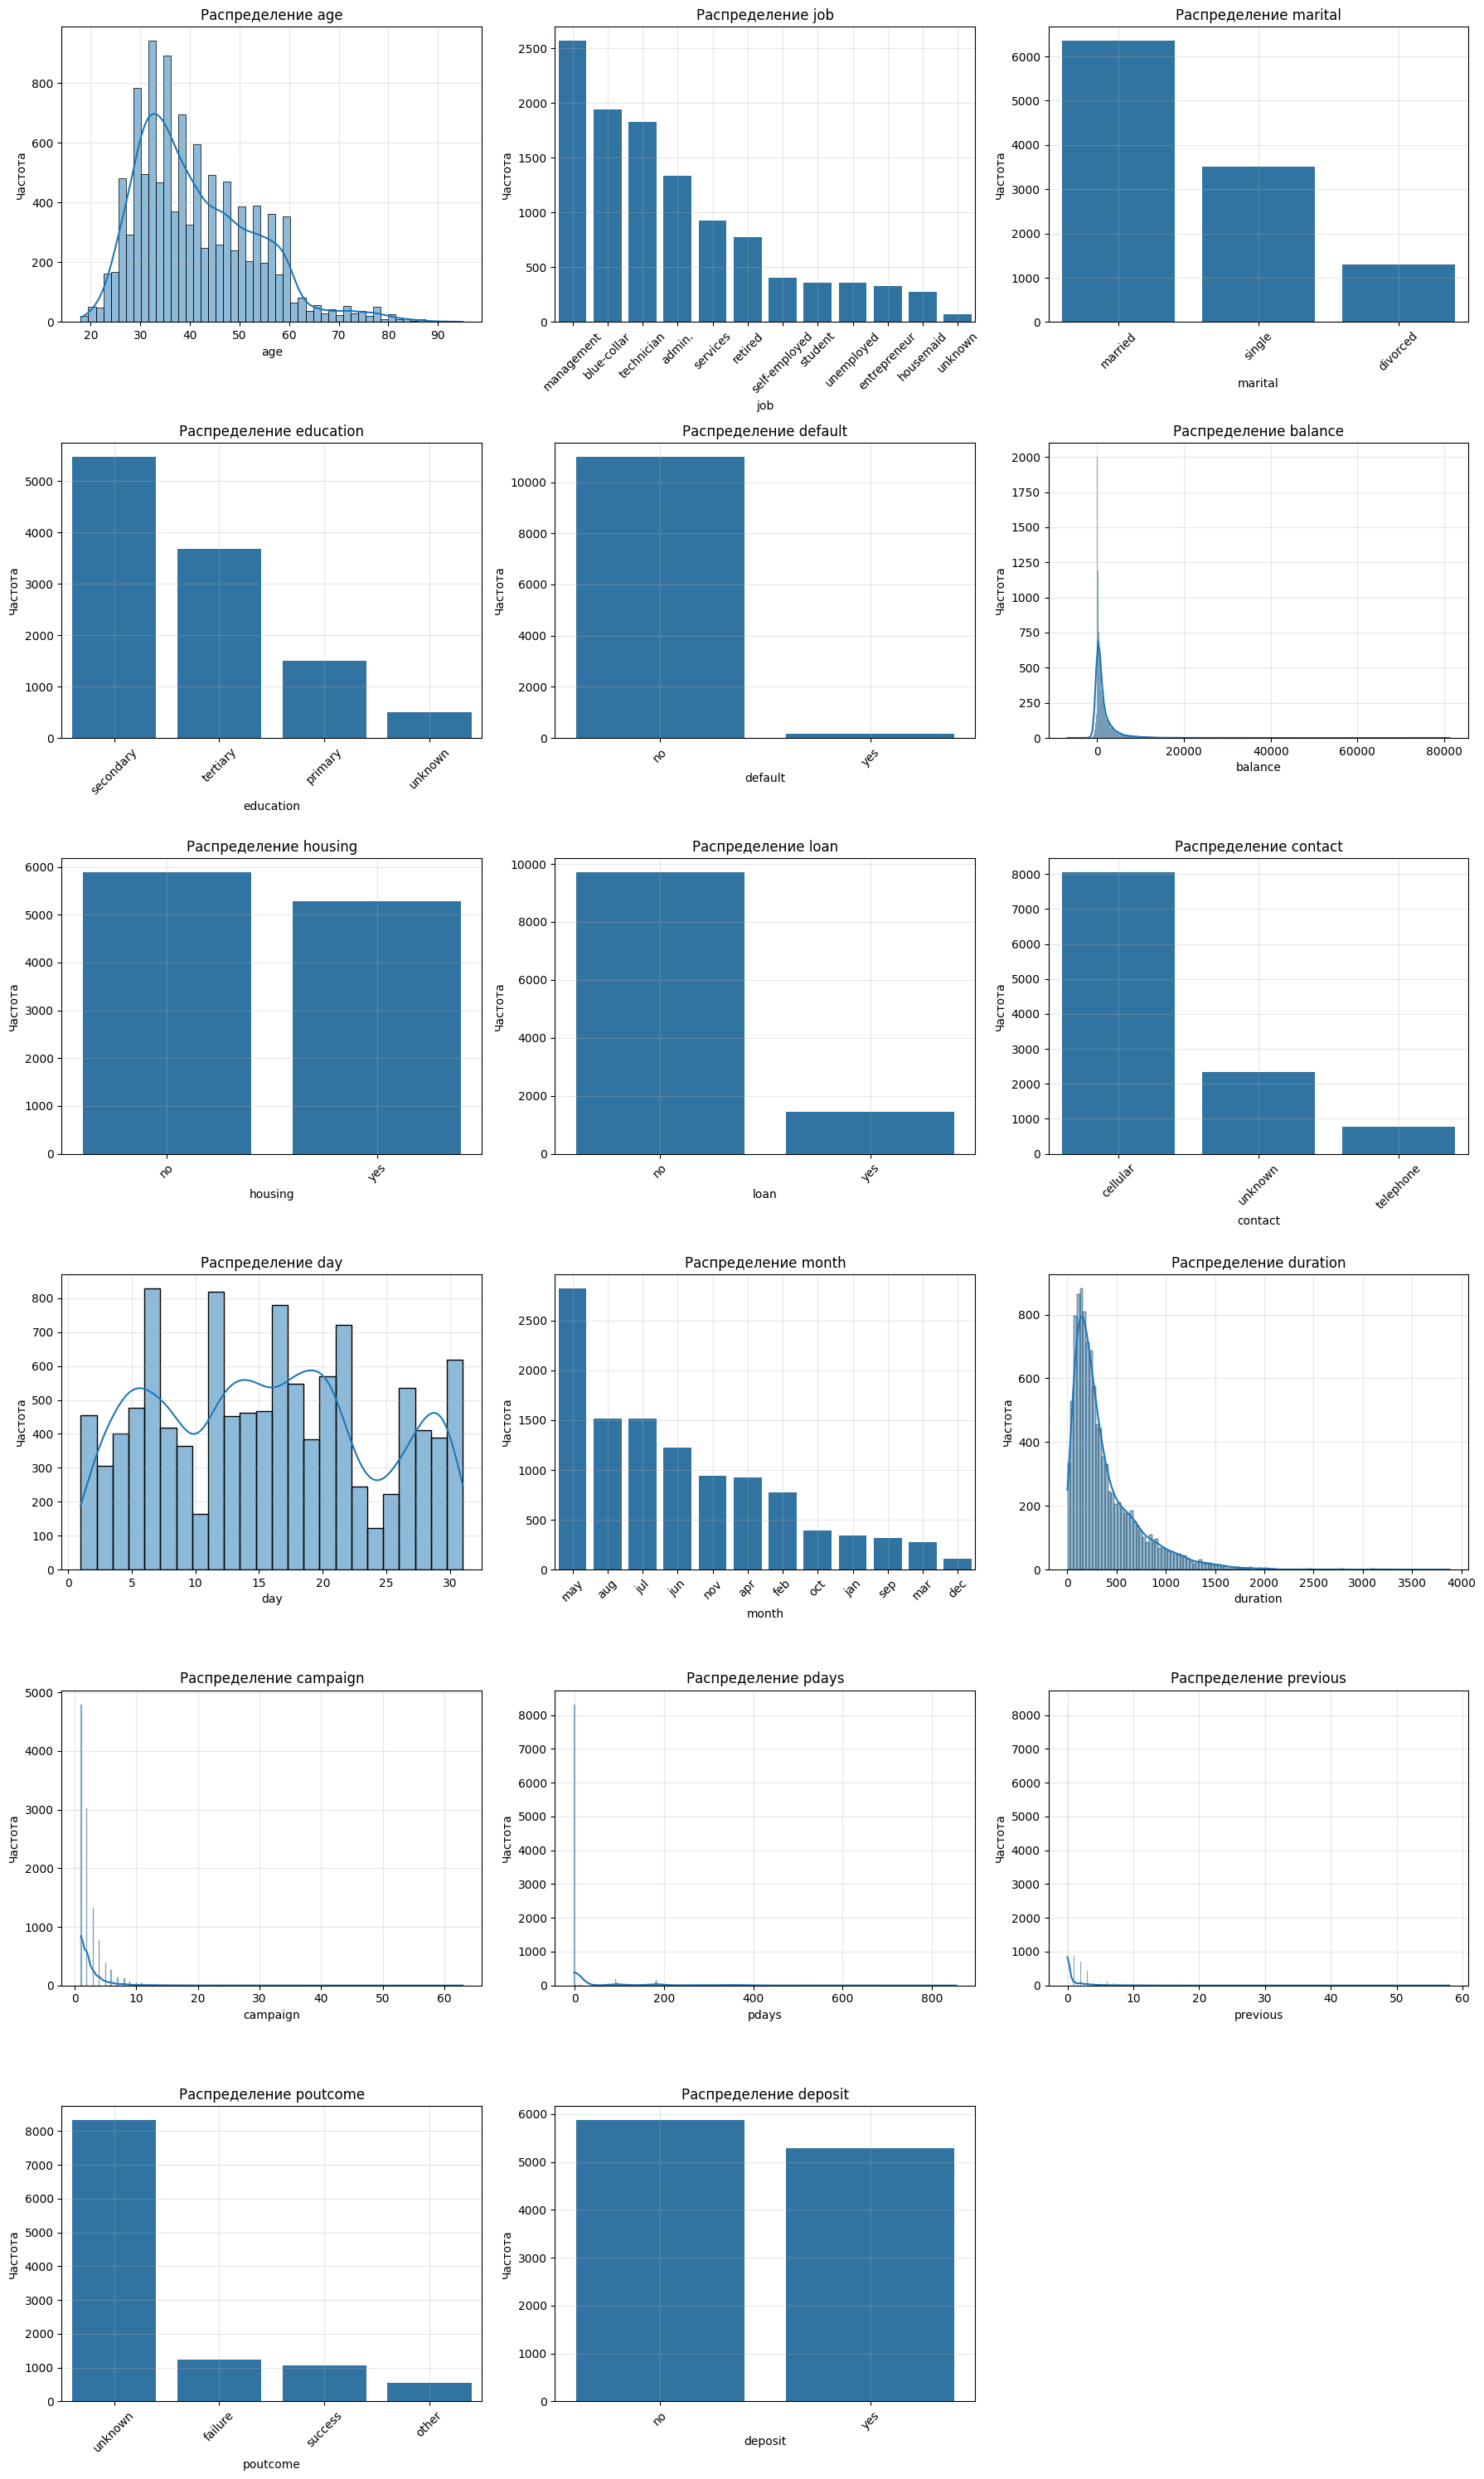

In [ ]:
plot_all_features(df)

Видим большое количество пропусков unknown -> заменим модой или полностью удалим при превышении порога.

In [ ]:
def handle_unknown(df: pd.DataFrame, threshold: int = 30) -> pd.DataFrame:
    df_clean = df.copy()
    cat_features = df.select_dtypes(exclude=np.number).columns.tolist()
    for column in cat_features:
        unknown_count = (df_clean[column] == 'unknown').sum()
        if unknown_count > 0:
            high_unknown = ((df_clean[column] == 'unknown').mean() * 100) > threshold
            if high_unknown:
                df_clean = df_clean.drop(column, axis=1)
            else:
                cat_wt_unknown = df_clean.loc[~(df_clean[column] == 'unknown'), column]
                mode_val = cat_wt_unknown.mode()
                if mode_val.empty:
                    df_clean.loc[(df_clean[column] == 'unknown'), column] = 'None'
                else:
                    df_clean.loc[(df_clean[column] == 'unknown'), column] = mode_val.iloc[0]
    return df_clean

In [ ]:
df = handle_unknown(df)

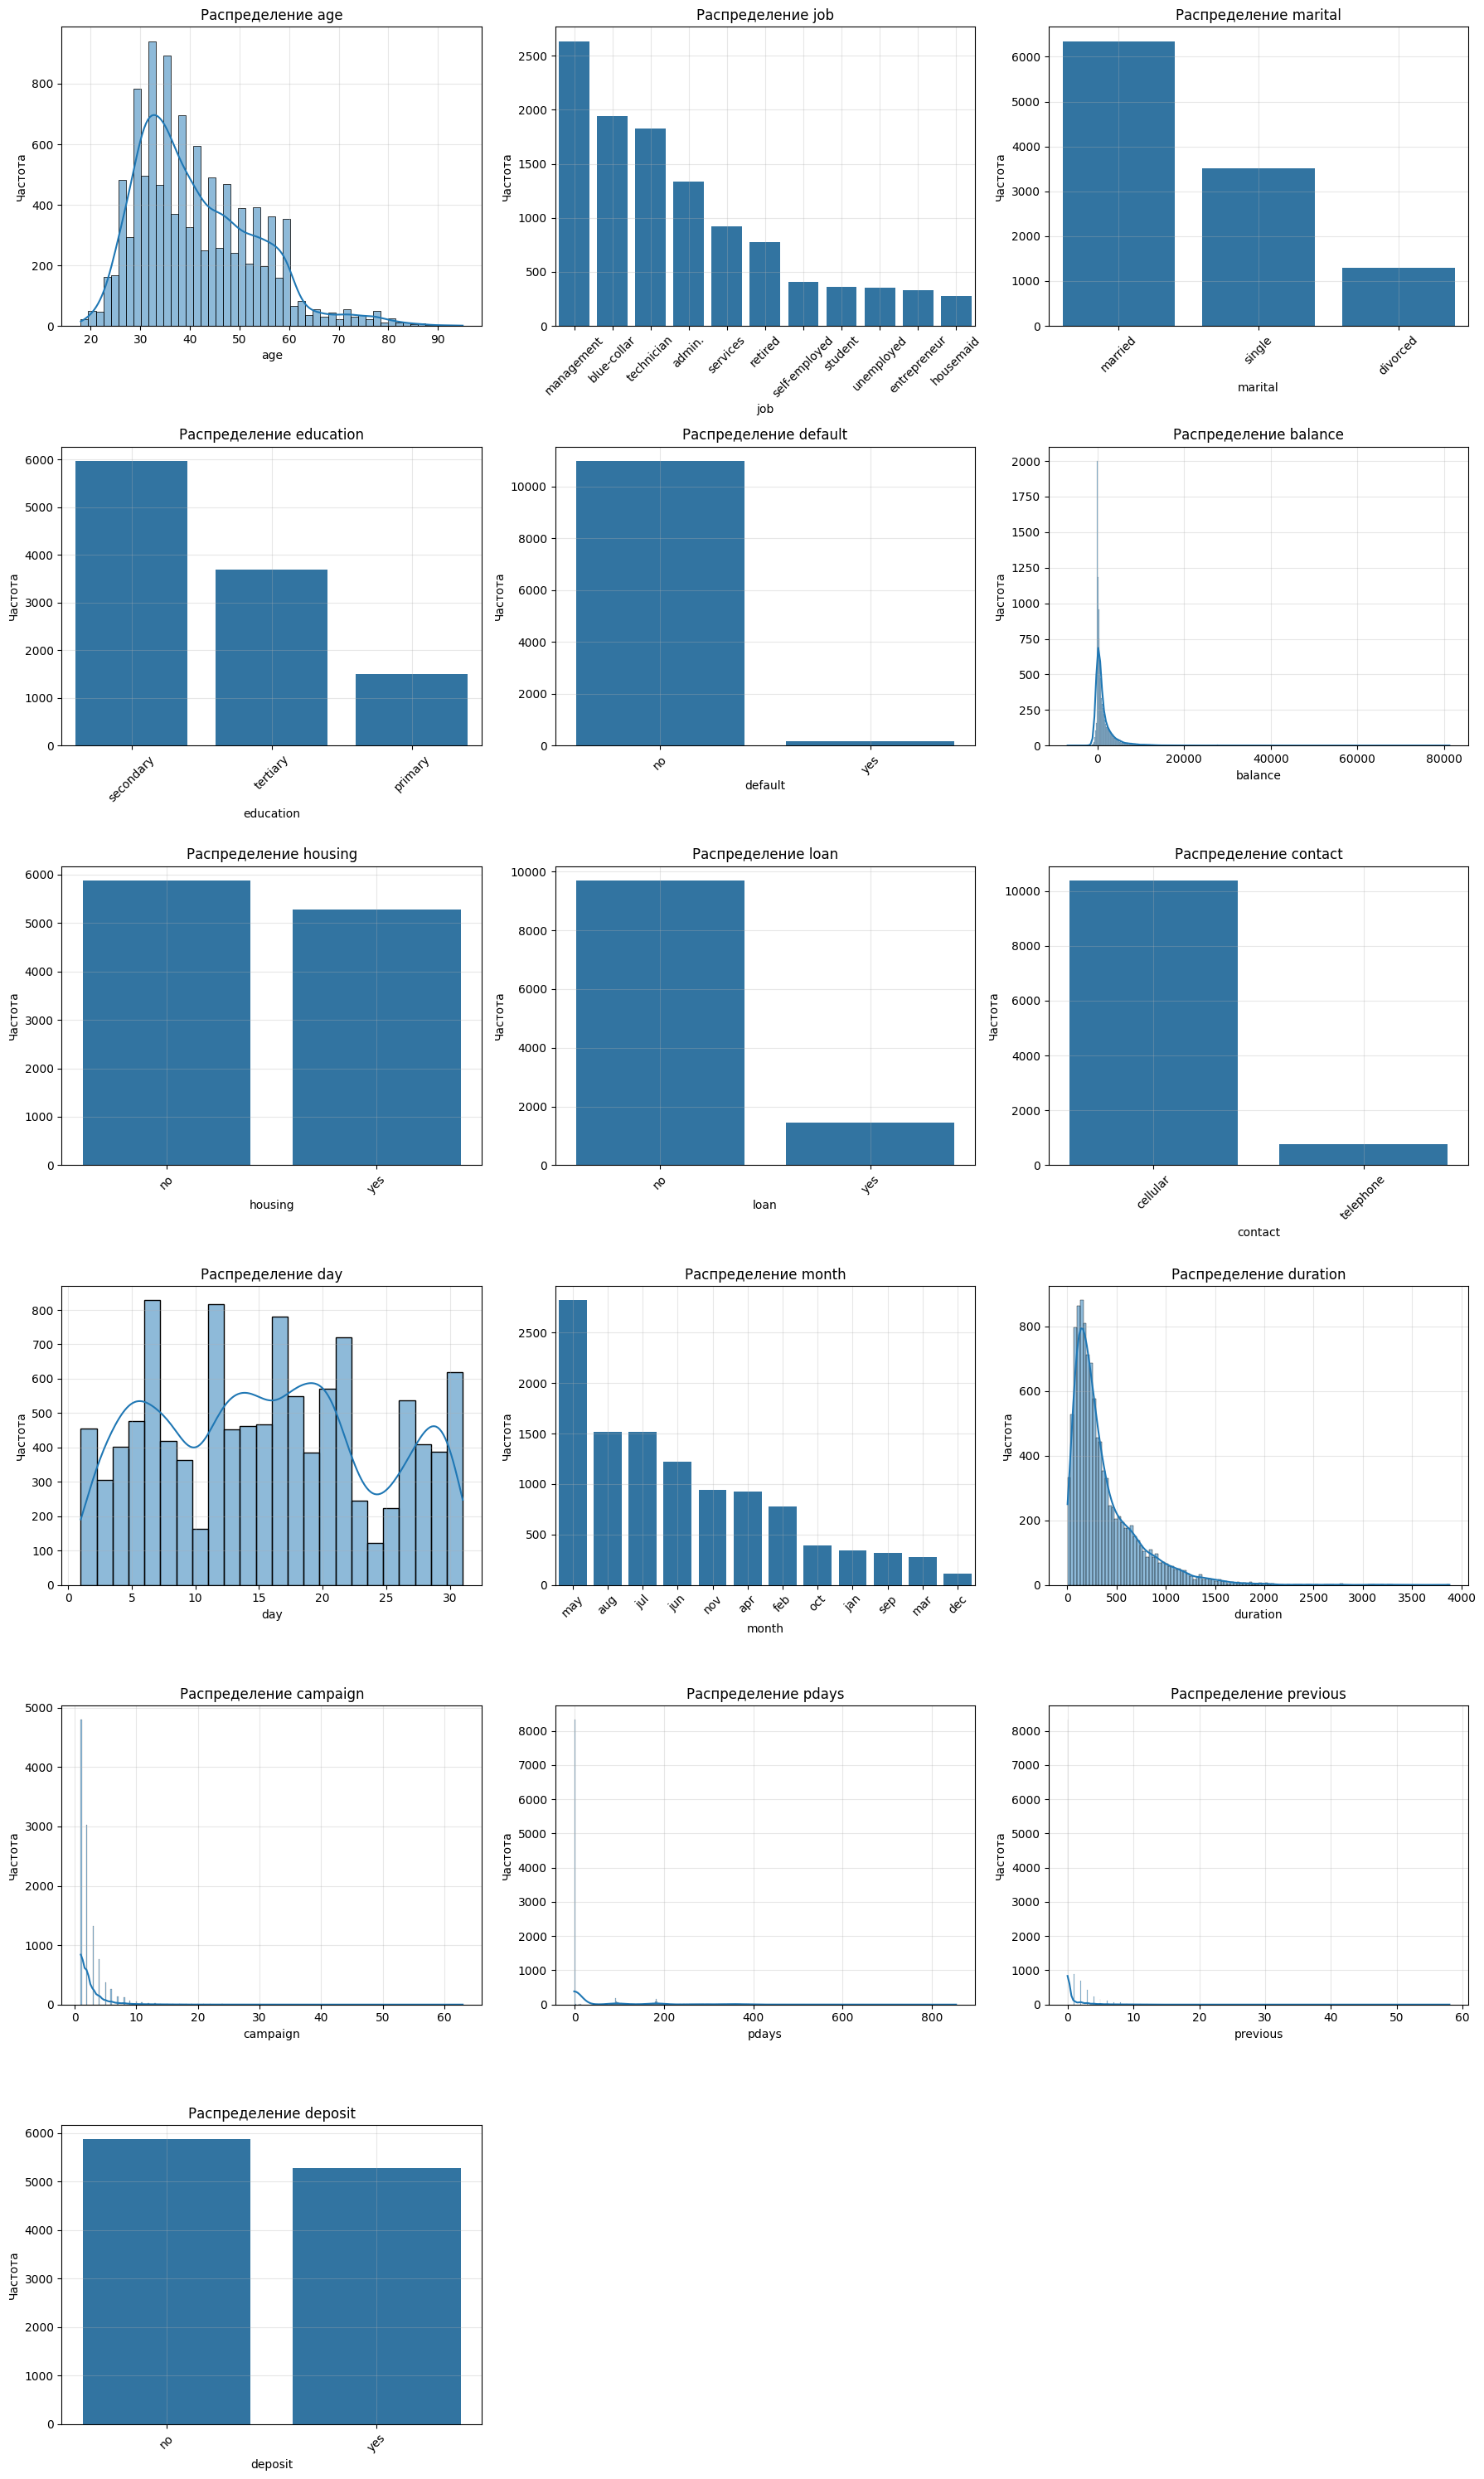

In [ ]:
plot_all_features(df)

Для избежания data leakage сначала разделим на train и test, а потом применим label encoding

In [ ]:
X = df.drop('deposit', axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Преобразуем категориальные данные в числовые (LabelEncoder)

Для месяцев используем циклическое кодирование, чтобы модель не терялась между логически близкими месяцами (декабрь 12 и январь 1)

In [ ]:
cat_features = X_train.select_dtypes(include='object').columns.tolist()
encoders = {}

month_order = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
X_train['month_num'] = X_train['month'].map(month_order)
X_test['month_num'] = X_test['month'].map(month_order)

X_train['month_sin'] = X_train['month_num'].apply(lambda x: np.sin(2 * np.pi * x / 12))
X_train['month_cos'] = X_train['month_num'].apply(lambda x: np.cos(2 * np.pi * x / 12))

X_test['month_sin'] = X_test['month_num'].apply(lambda x: np.sin(2 * np.pi * x / 12))
X_test['month_cos'] = X_test['month_num'].apply(lambda x: np.cos(2 * np.pi * x / 12))

X_train = X_train.drop(columns=['month', 'month_num'])
X_test = X_test.drop(columns=['month', 'month_num'])
if 'month' in cat_features:
    cat_features.remove('month')

if y_train.dtype == 'object' and y_test.dtype == 'object':
    y_train = pd.Series((y_train == 'yes').astype(int))
    y_test = pd.Series((y_test == 'yes').astype(int))
for feature in cat_features:
    le = LabelEncoder()
    X_train[feature] = le.fit_transform(X_train[feature])
    X_test[feature] = le.transform(X_test[feature])
    encoders[feature] = le


In [ ]:
y_train.head()

8644    0
2632    1
3056    1
1080    1
4006    1
Name: deposit, dtype: int64

In [ ]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,duration,campaign,pdays,previous,month_sin,month_cos
8644,46,0,1,1,0,526,0,1,0,31,251,3,-1,0,-0.5,-8.660254e-01
2632,46,0,1,2,0,2552,0,0,0,3,260,1,94,8,-1.0,-1.836970e-16
3056,25,9,2,1,0,139,0,1,0,11,202,1,91,1,0.5,8.660254e-01
1080,43,9,1,1,0,3288,1,0,0,21,775,3,-1,0,-0.5,8.660254e-01
4006,37,1,2,1,0,217,0,0,0,23,272,2,-1,0,-1.0,-1.836970e-16


Напишем функцию, которая вернет интерпретируемость в колонки с месяцами

In [ ]:
def sincos_to_month(feature: str, threshold: float, operator: str):
    month_order = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    }
    month_df = pd.DataFrame({
        'month': month_order.keys(),
        'num': month_order.values()
    })
    month_df['month_sin'] = month_df['num'].apply(lambda x: np.sin(2 * np.pi * x / 12))
    month_df['month_cos'] = month_df['num'].apply(lambda x: np.cos(2 * np.pi * x / 12))
    if feature == 'month_sin':
        if operator == '<=':
            filtered_months = month_df[month_df['month_sin'] <= threshold]['month'].tolist()
        else:
            filtered_months = month_df[month_df['month_sin'] > threshold]['month'].tolist()
    elif feature == 'month_cos':
        if operator == '<=':
            filtered_months = month_df[month_df['month_cos'] <= threshold]['month'].tolist()
        else:
            filtered_months = month_df[month_df['month_cos'] > threshold]['month'].tolist()
    else:
        return 'Wrong feature name'
    filtered_str = ', '.join(filtered_months)
    return f'{feature} {operator} {threshold} -> {filtered_str}'

# Часть 1: Решающие деревья ( 3 балла)

Постройте решающее дерево для классификации с максимальной глубиной 3. Визуализируйте дерево и ответьте:

- Какие 3 признака оказались самыми важными на верхнем уровне дерева?

- Какой лист содержит наибольшее количество объектов и каково его предсказание?

In [ ]:
decision_tree = DecisionTreeClassifier(
    random_state=42,
    max_depth=3
)
decision_tree.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


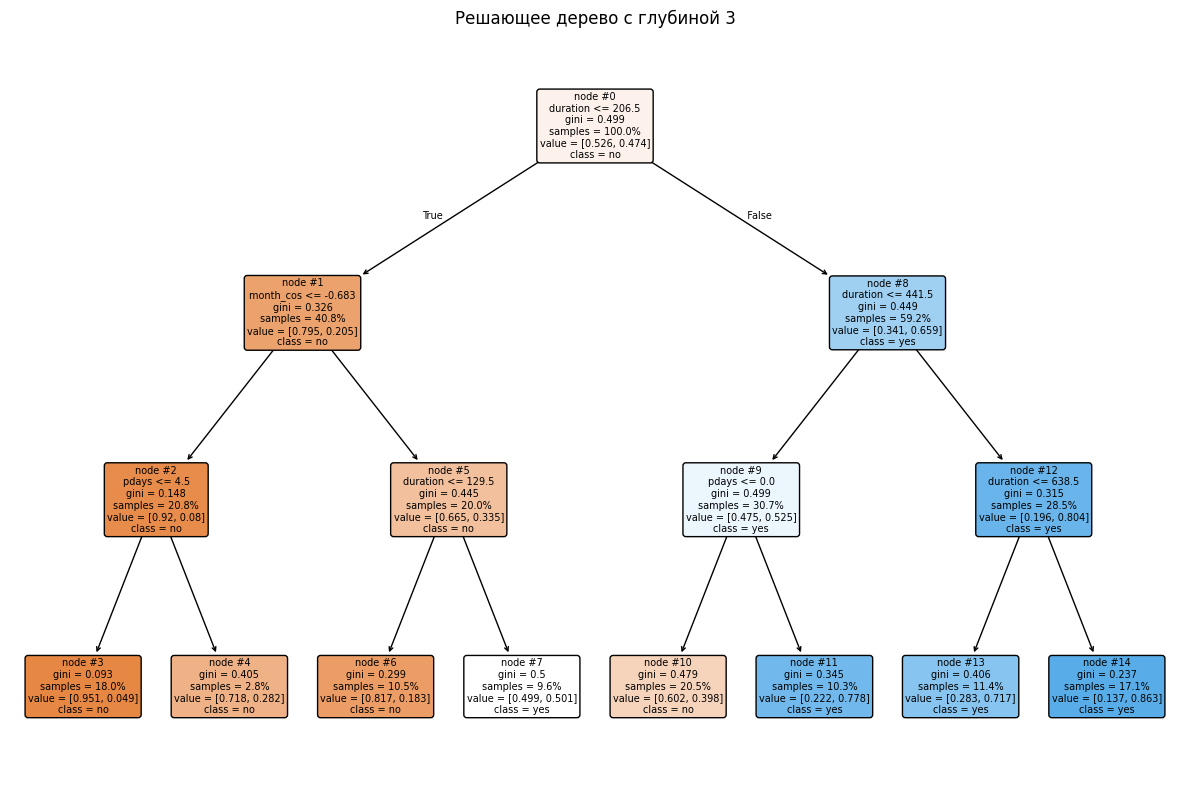

In [ ]:
plt.figure(figsize=(12,8))
plot_tree(
    decision_tree=decision_tree,
    feature_names=X_train.columns.tolist(),
    class_names=['no', 'yes'],
    filled=True,
    proportion=True,
    rounded=True,
    node_ids=True
)
plt.title('Решающее дерево с глубиной 3')
plt.tight_layout()
plt.show()

### Какие 3 признака оказались самыми важными на верхнем уровне дерева?

Наиболее важными оказались duration, month_cos, pdays. Выбор был сделан по количеству семплов, которое затрагивает каждый узел.

duration -> чем дольше длилась последняя беседа с клиентом, тем больше шанс того, что он согласится оформить депозит.

pdays -> в этом узле идет разделение по количеству дней с последнего контакта с клиентом в предыдущей кампании. В случае отрицательного pdays, как, например, в node #9 переход налево означает, что с клиентом еще не контактировали ранее, то есть если с клиентом говорить 3-7 минут и ранее с ним не общаться, то скорее всего он откажет.

month_cos -> с помощью этой фичи можем отловить сезонные паттерны на депозит. Так модель считает, что оформление депозита в мае, июне и июле ниже, чем в другие периоды. Возможно, это связано с сезоном отпусков, в который клиенты не очень хотят совершать финансовые решения




In [ ]:
sincos_to_month('month_cos', -0.683, '<=')

'month_cos <= -0.683 -> may, jun, jul'

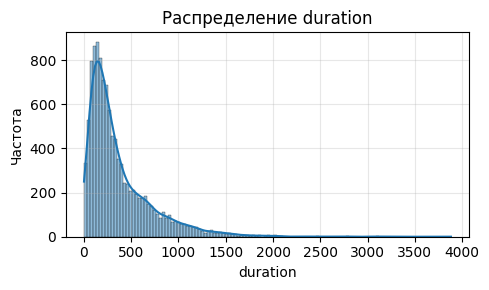

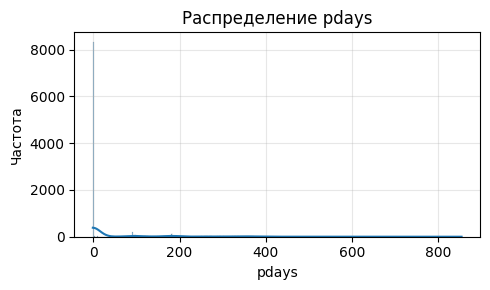

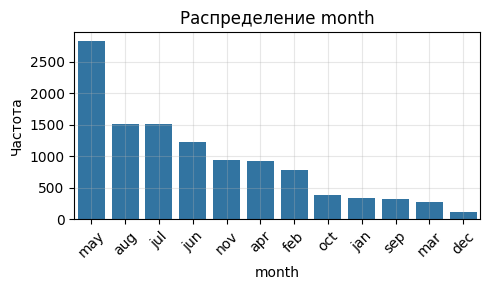

In [ ]:
plot_feature(df, 'duration', (5, 3))
plot_feature(df,'pdays', (5, 3))
plot_feature(df, 'month', (5, 3))

### Какой лист содержит наибольшее количество объектов и каково его предсказание?

Наибольшее количество объектов (20,5%) содержит node #10. Путь к нему определяет итоговую длину разговора duration и количество дней с предыдущего контакта pdays. Итак, в 60% случаев клиент откажется от депозита, если звонок длится от 3,5 до 7,5 минут, при этом ранее с ним никак не контактировали.

Ответ на вопрос:

- Проведите эксперимент с разной глубиной дерева (от 2 до 10). Постройте график:

Ось X: глубина дерева

Ось Y: accuracy на тренировочной и тестовой выборках

Так как максимальная accuracy достигается на глубине 10, рассмотрим, как будут вести себя кривые на больших глубинах.

In [ ]:
train_accs = []
test_accs = []
depths = np.arange(2, 20)
for depth in depths:
    dt = DecisionTreeClassifier(
        random_state=42,
        max_depth=depth
    )
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    test_pred = dt.predict(X_test)
    train_accs.append(accuracy_score(y_train, train_pred))
    test_accs.append(accuracy_score(y_test, test_pred))
dt_acc = np.max(test_accs)
mx_depth = depths[int(np.argmax(test_accs))]
print(f'Максимальная accuracy {dt_acc:.4f} достигается на глубине {mx_depth}')

Максимальная accuracy 0.8285 достигается на глубине 10


In [ ]:
def train_test_acc(depths: list, train_accs: list, test_accs: list):
    plt.figure(figsize=(10, 6))
    plt.plot(depths, train_accs, marker='o', label='Train Accuracy')
    plt.plot(depths, test_accs, marker='o', label='Test Accuracy')

    mx_depth = depths[int(np.argmax(test_accs))]

    plt.axvline(mx_depth, linestyle='--', color='r', alpha=0.5, label='Оптимальная глубина')
    plt.grid(True, alpha=0.3)
    plt.title('Зависимость accuracy от глубины')
    plt.xlabel('Глубина дерева')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

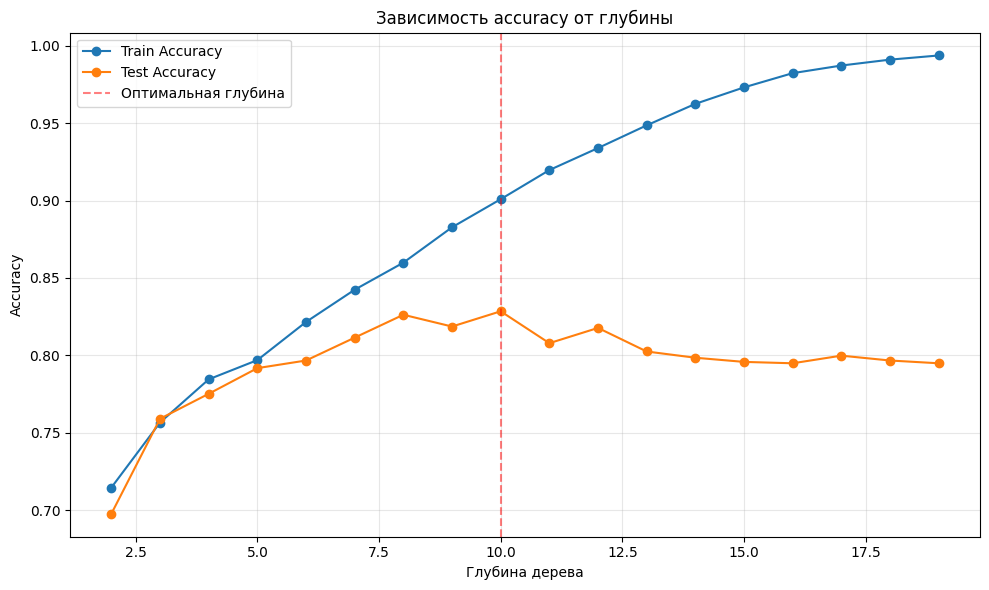

In [ ]:
train_test_acc(depths, train_accs, test_accs)

- Объясните, наблюдаете ли вы переобучение. На какой глубине оно начинает проявляться?
- Сравните поведение accuracy на тренировочной и тестовой выборках.

Переобучение наблюдается, когда кривые accuracy на тренировочной и тестовой выборках начинают расходиться - максимум теста был достигнут на глубине дерева 9, далее кривая теста остается такой же, либо немного убывает. В это же время тренировочная accuracy продолжает расти - модель учит шумы и выбросы, полностью запоминает всю выборку. При увеличении глубины дерева далее, переобучение будет лишь расти, а accuracy тестовой выборки падать.

Глубина 2->3 -- наблюдаем недообучение, когда модель только начинает понимать закономерности на трейне, но у нее не хватает глубины для четкого создания зависимостей в данных. К глубине 3 и тест, и трейн достигают одинакового accuracy, то есть недообучение заканчивается

Глубина 4->8 -- период, на котором accuracy на обеих выборках быстро растет, следовательно есть смысл повышать глубину и смотреть, что будет дальше

Глубина 8->9 -- начинает проявляться переобучение, кривые начинают расходиться, а трейн на глубине 9 немного падает. На этой глубине модель работает лучше, чем ранее, у нее есть необходимый запас глубины для составления зависимостей, в то же время она не уходит в излишне шумовые связи вроде "клиенты с duration = 215,3 без кредита на дом оформляют депозит хуже других".

Глубина 10 -- модель достигает лучшего показателя accuracy на тесте, при этом не уходя слишком сильно в переобучение.

Глубина > 10 -- видим ухудшающийся процесс переобучения. Трейн всё продолжает расти, запоминает разные бредовые связи, доводя accuracy до 1, а тест быстро начинает падать.

# Часть 2: Случайный лес ( 3 балла)

Обучите случайный лес с 100 деревьями. Сравните его производительность с лучшим одиночным деревом из Части 1.

- На сколько процентов улучшилась accuracy?

- Как изменилось переобучение?

In [ ]:
def print_metric_diff(fst_name:str, fst_acc: float, scnd_name: str, scnd_acc: float):
    if scnd_acc > fst_acc:
        scnd_acc, fst_acc = fst_acc, scnd_acc
        scnd_name, fst_name = fst_name, scnd_name
    print(f'Accuracy {fst_name} -> {fst_acc:.4f}')
    print(f'Accuracy {scnd_name} -> {scnd_acc:.4f}')
    print(f'Accuracy difference -> {(1 - (scnd_acc / fst_acc)) * 100:.2f}%')

In [ ]:
random_forest = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=9
)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print_metric_diff('Random Forest', rf_acc, 'Decision Tree', dt_acc)

Accuracy Random Forest -> 0.8437
Accuracy Decision Tree -> 0.8285
Accuracy difference -> 1.80%


Для наглядности рассмотрим зависимость acccuracy от глубины случайного леса

In [ ]:
temp_train_accs = []
temp_test_accs = []
temp_depths = np.arange(2, 25)
for depth in temp_depths:
    temp_random_forest = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=depth
    )
    temp_random_forest.fit(X_train, y_train)
    temp_train_pred = temp_random_forest.predict(X_train)
    temp_test_pred = temp_random_forest.predict(X_test)
    temp_train_accs.append(accuracy_score(y_train, temp_train_pred))
    temp_test_accs.append(accuracy_score(y_test, temp_test_pred))
temp_rf_acc = np.max(temp_test_accs)
temp_mx_depth = temp_depths[int(np.argmax(temp_test_accs))]
print(f'Максимальная accuracy {temp_rf_acc:.4f} достигается на глубине {temp_mx_depth}')

Максимальная accuracy 0.8536 достигается на глубине 15


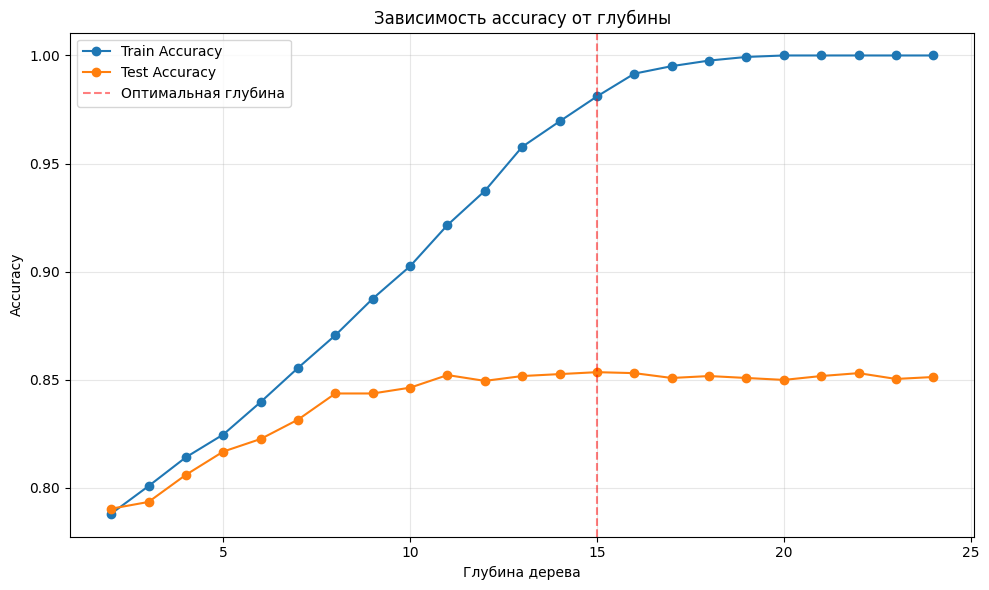

In [ ]:
train_test_acc(temp_depths, temp_train_accs, temp_test_accs)

Видим, что кривые accuracy начинают расходиться уже на глубине 8, но случайный лес все продолжает расти и достигает максимального значения при глубине 15, что уже лучше, чем у одиночного дерева на 5 пунктов -> достигаем переобучения на большей глубине, а значит модель более качественная, чем базовая. При дальнейшем увеличении глубины accuracy теста падает, трейн запоминается слишком хорошо, а значит, модель переобучается и смысла увеличивать глубину нет.

- Проанализируйте важность признаков в случайном лесе.
 - Сравните ТОП-5 признаков с ТОП-5 из одиночного дерева. Объясните, почему списки могут отличаться.

In [ ]:
def get_feature_importance(df: pd.DataFrame, model):
    importance = model.feature_importances_
    feature_df = pd.DataFrame({
        'Feature': df.columns,
        'Importance': importance
    })

    # Объединяем циклические составляющие месяца в один признак
    if 'month_sin' in feature_df['Feature'].values and 'month_cos' in feature_df['Feature'].values:
        sin_importance = feature_df.loc[feature_df['Feature'] == 'month_sin', 'Importance'].values[0]
        cos_importance = feature_df.loc[feature_df['Feature'] == 'month_cos', 'Importance'].values[0]
        month_importance = sin_importance + cos_importance
        feature_df = feature_df[~feature_df['Feature'].isin(['month_sin', 'month_cos'])]
        feature_df = pd.concat([
            feature_df,
            pd.DataFrame({
                'Feature': ['month'],
                'Importance': month_importance
            })],
            ignore_index=True
        )
        feature_df['Importance'] = feature_df['Importance'] / feature_df['Importance'].sum()

    return feature_df.sort_values('Importance', ascending=False)

Случайный лес определяет, будет ли оформлен депозит, в основном полагаясь на продолжительность звонка, сезонность, количество дней с последней компании, а день, в который был совершен звонок, что в целом совпадает с деревом решений.

Как видно из таблицы продолжительность звонка играет решающую роль, так как занимает целых 48% от общей важности признаков.

In [ ]:
print('Важность признаков случайного леса')
get_feature_importance(X_train, random_forest)

Важность признаков случайного леса


,Feature,Importance
10,duration,0.487105
14,month,0.124542
12,pdays,0.076774
9,day,0.054127
0,age,0.054093
6,housing,0.047836
13,previous,0.044932
5,balance,0.044462
11,campaign,0.020071
1,job,0.015668


In [ ]:
def show_top_features(model_name: str, importance_df: pd.DataFrame, top_n: int = 5):
    top_features = importance_df.head(top_n)
    plt.figure(figsize=(10,6))
    sns.barplot(x=top_features['Importance'], y=top_features['Feature'])
    plt.grid(True, alpha=0.3)
    plt.title(f'Топ {top_n} признаков модели {model_name}')
    plt.xlabel('Важность')
    plt.ylabel('Признак')
    plt.tight_layout()
    plt.show()

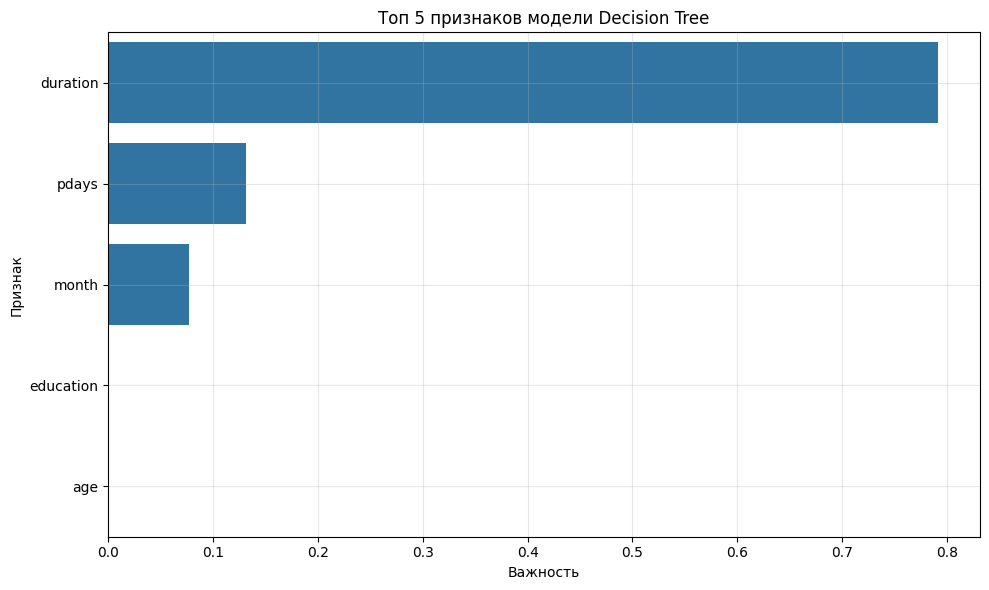

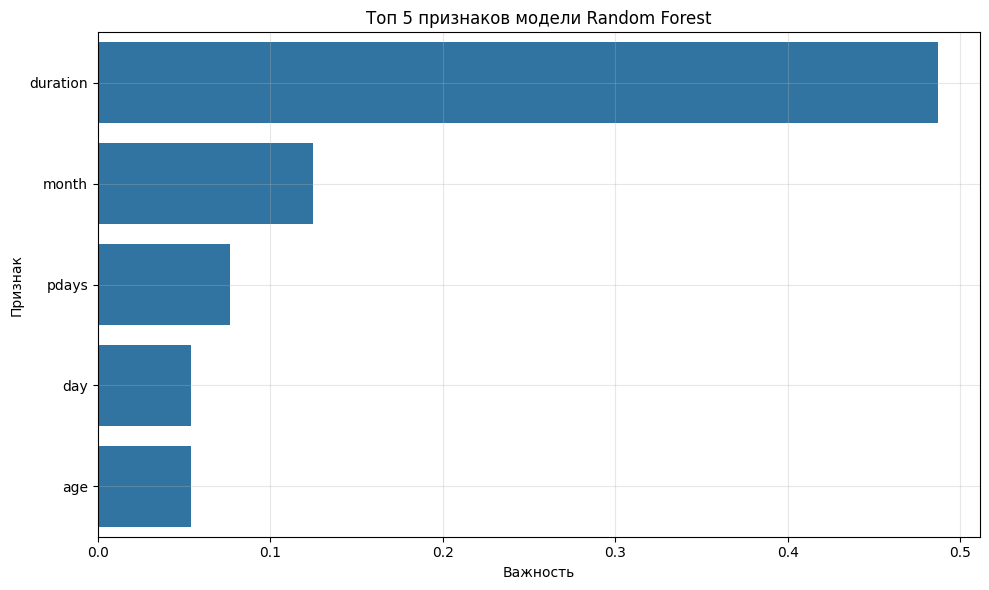

In [ ]:
models = {
    'Decision Tree': decision_tree,
    'Random Forest': random_forest
}
for name, model in models.items():
    importance_df = get_feature_importance(X_train, model)
    show_top_features(name, importance_df)

Видим, что дерево решений в процессе обучения выделило для себя 3 главных признака до глубины 10. Практически полностью оно полагается на duration, чуть меньше на количество дней с последнего контакта и сезонность. Остальные признаки решающее дерево посчитало совершенно неважными.

Случайный лес же состоит из сотни деревьев решений, каждому из которых показывали разные признаки, затем финальная важность получалась из усреднения важностей всех составляющих деревьев. В этом подходе видим, что для предсказания модель по большей части так же ориентируется на длительность беседы, однако теперь намного более важную роль стали играть сезонность, pdays (поднялся выше способа контакта), день контакта и возраст клиента.

Итак, видим, что случайный лес более надежен и в плане достижения переобучения, и в плане выбора наиболее важных для предсказания результата признаков благодаря своему комплексному устройству.

# Часть 3: Градиентный бустинг ( 3 балла)

- Обучите модель градиентного бустинга (CatBoost или XGBoost). Проведите эксперимент с learning rate:

   *  learning rate = 0.01

   * learning rate = 0.1

   * learning rate = 0.3




In [ ]:
def catboost_acc_lr( X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame, rate: float = 0.01) -> float:
    boost = CatBoostClassifier(
        random_seed=42,
        learning_rate=rate,
        eval_metric='Accuracy',
        verbose=0
    )
    boost.fit(X_train, y_train)
    y_pred_cb = boost.predict(X_test)
    acc_cb = accuracy_score(y_test, y_pred_cb)
    return boost, acc_cb

In [ ]:
rates = [0.01, 0.1, 0.3]
for rate in rates:
    catboost_model = catboost_acc_lr(X_train, y_train, X_test, y_test, rate)
    print(f'Learning rate -> {rate}  --  Accuracy -> {catboost_model[1]:.4f}')

Learning rate -> 0.01  --  Accuracy -> 0.8504
Learning rate -> 0.1  --  Accuracy -> 0.8536
Learning rate -> 0.3  --  Accuracy -> 0.8509


Наиболее оптимальным из темпов обучения оказался 0.1 -> посмотрим важность признаков модели

In [ ]:
def get_feature_importance_cb(df: pd.DataFrame, model):
    importance = model.get_feature_importance()
    feature_df = pd.DataFrame({
        'Feature': df.columns,
        'Importance': importance
    })

    # Объединяем циклические составляющие месяца в один признак
    if 'month_sin' in feature_df['Feature'].values and 'month_cos' in feature_df['Feature'].values:
        sin_importance = feature_df.loc[feature_df['Feature'] == 'month_sin', 'Importance'].values[0]
        cos_importance = feature_df.loc[feature_df['Feature'] == 'month_cos', 'Importance'].values[0]
        month_importance = sin_importance + cos_importance
        feature_df = feature_df[~feature_df['Feature'].isin(['month_sin', 'month_cos'])]
        feature_df = pd.concat([
            feature_df,
            pd.DataFrame({
                'Feature': ['month'],
                'Importance': month_importance
            })],
            ignore_index=True
        )
        feature_df['Importance'] = feature_df['Importance'] / feature_df['Importance'].sum()

    return feature_df.sort_values('Importance', ascending=False)

Catboost при решении задачи классификации обращает внимание на продолжительность звонка, сезонность, возраст клиента и день контакта, однако, в отличие от других моделей, он считает важными ещё и баланс лицевого счета клиента, причем важность всех признаков, в отличие от случайного леса и тем более отдельного дерева решений, примерно равнозначна

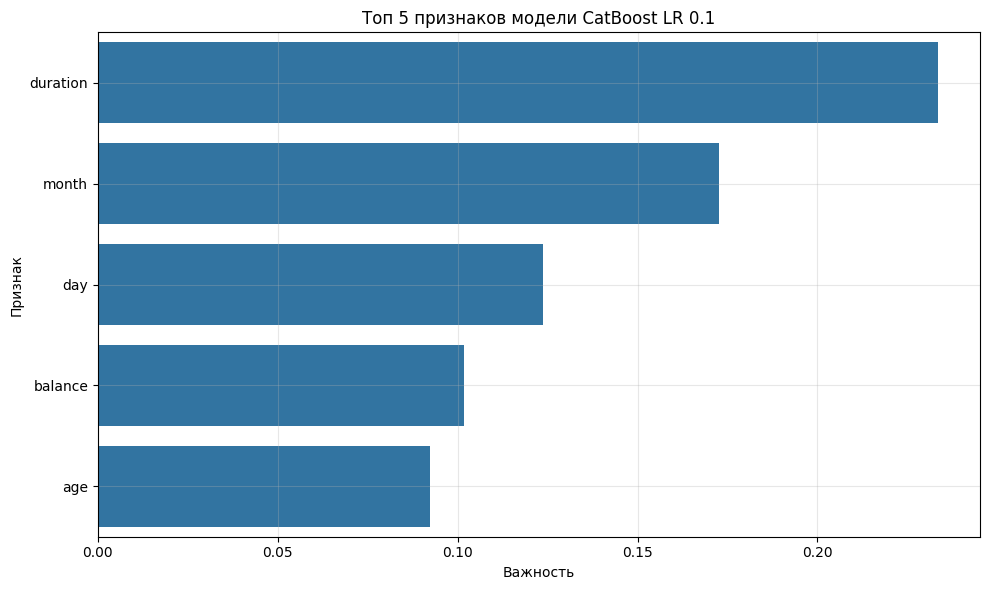

In [ ]:
boost = CatBoostClassifier(
        random_seed=42,
        learning_rate=0.1,
        eval_metric='Accuracy',
        verbose=0
    )
boost.fit(X_train, y_train)
cb_acc = accuracy_score(y_test, boost.predict(X_test))
top_boost = get_feature_importance_cb(X_train, boost)
show_top_features('CatBoost LR 0.1', top_boost)

- Сравните бустинг со случайным лесом по следующим параметрам:

    - Точность (accuracy)
    - Интерпретируемость

Catboost практически идентичен Random Forest по Accuracy, отличие составляет 1,66%. Так получается из-за бустинга, на котором работает catboost - каждое следующее дерево корректирует ошибки предыдущих, двигаясь по напрвлению к антиградиенту, что в этой задаче эффективнее, чем усреднение предсказаний деревьев случайного леса.

И catboost, и случайный лес достаточно интерпретируемы - после обучения можем просматривать важность признаков для модели, однако random forest все же немного проще понять как минимум из-за того, что мы можем визуализировать деревья и видеть каждый шаг, ведущий к решению о взятии депозита. Для подобной визуализации в catboost используют SHAP - наиболее интерпретируемыми для меня стали beeswarm и dependence_plot. Они выглядят сложнее, но с опытом в них можно ориентироваться так же быстро, как и в деревьях. Кроме того, плюсом интерпретируемости кетбуста является вывод информации о каждой итерации модели с оценкой при verbose > 0.

Accuracy Catboost -> 0.8536
Accuracy Random Forest -> 0.8437
Accuracy difference -> 1.15%


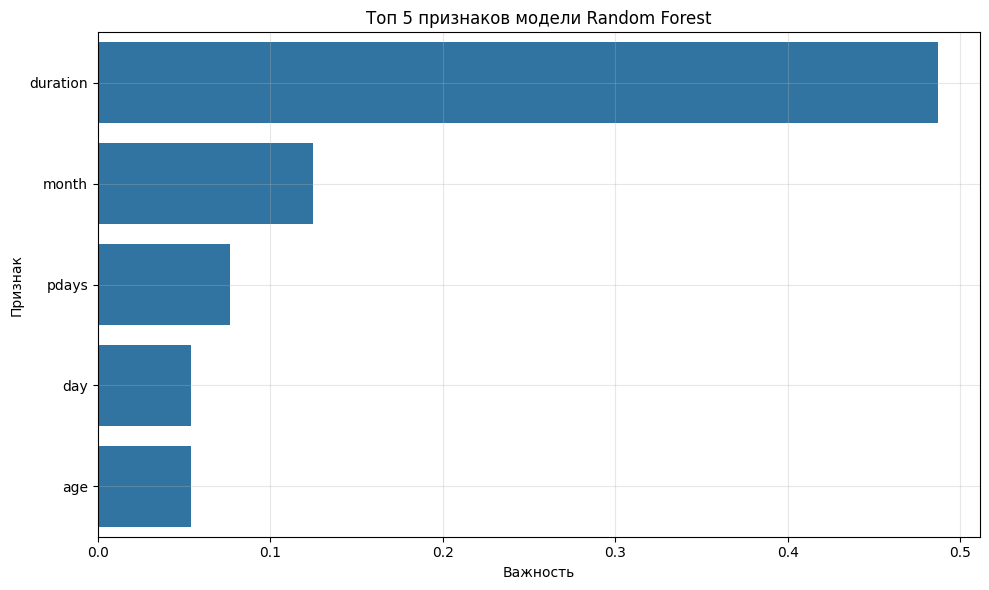

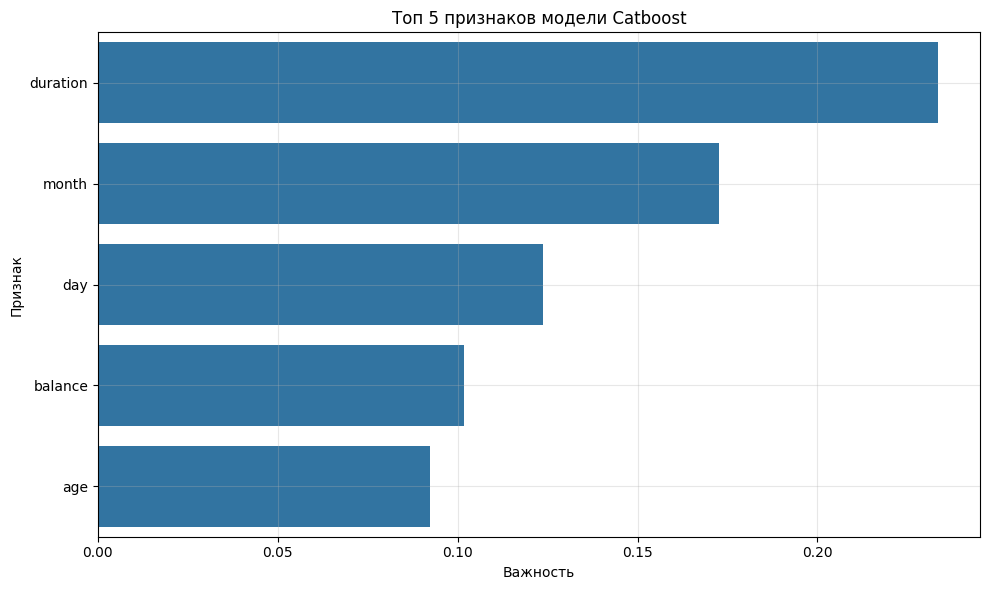

In [ ]:
models = {
    'Random Forest': random_forest,
    'Catboost': boost
}
print_metric_diff('Catboost', cb_acc, 'Random Forest', rf_acc)

for name, model in models.items():
    importance_df = get_feature_importance(X_train, model)
    show_top_features(name, importance_df)

- Примените технику Target Encoding к категориальным признакам в CatBoost.
- Сравните результаты с one-hot encoding.
- Какой метод показал лучшую производительность и напиши выводы?



In [ ]:
X = df.drop('deposit', axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

cat_features = X_train.select_dtypes(include='object').columns.tolist()

te_boost = CatBoostClassifier(
    random_seed=42,
    cat_features=cat_features,
    one_hot_max_size=0, # Все категориальные признаки будут кодироваться target encoding
    simple_ctr=["Borders:TargetBorderCount=1:Prior=0.5"],
    combinations_ctr=["Borders:TargetBorderCount=1"],
    verbose=0,
    eval_metric='Accuracy'
)
oh_boost = CatBoostClassifier(
    random_seed=42,
    cat_features=cat_features,
    one_hot_max_size=1000, # Оставляем только One hot encoding
    max_ctr_complexity=0,
    simple_ctr=[],
    combinations_ctr=[],
    verbose=0,
    eval_metric='Accuracy'
)

te_boost.fit(X_train, y_train)
oh_boost.fit(X_train, y_train)

te_acc = accuracy_score(y_test, te_boost.predict(X_test))
oh_acc = accuracy_score(y_test, oh_boost.predict(X_test))

print_metric_diff('Target Encoding CB', te_acc, 'One Hot CB', oh_acc)

Accuracy One Hot CB -> 0.8580
Accuracy Target Encoding CB -> 0.8495
Accuracy difference -> 0.99%


Выводы:

Разница в метриках незначительна, поэтому можно сказать, что оба способа показали одинаковый результат. Если говорить об отдельном использовании способов кодирования, то по производительности на малом количестве признаков, как в нашем датасете, побеждает one hot - каждый признак разделяется на много столбцов, где в соответствующем столбце ставится 1, в других 0. Так и разработчику легко интерпретировать результаты модели, важность признаков, так и модели проще обучаться и находить закономерности, однако, если слишком много уникальных признаков, то One hot будет создавать слишком много столбцов, тем самым замедляя скорость обучения модели и значительно повышая потребляемую моделью память. В этом случае уже лучше использовать Target Encoding, который каждой категории ставит в соответствие среднее значение целевой переменной по формуле encoded_value = mean(target | category), то есть данным вида

private -> 0

private -> 0

private -> 1

поставят в соответствие

private -> 1/3

В случае большого количества данных этот метод предпочтительнее, так как потребляет меньше памяти, модель обучается быстрее относительно One hot encoding.

А вообще предпочтительнее использовать Catboost без надстроек, так как он автоматически отмечает количество элементов категории и кодирует оптимальным способом - Target или One hot encoding.